In [14]:
import numpy as np
import matplotlib.pyplot as plt

from yaglm.toy_data import sample_sparse_lin_reg

from yaglm.Glm import Glm # the base class for all single fit estimators

# the model is specified with config objects
from yaglm.config.loss import LinReg, Huber, Quantile
from yaglm.config.penalty import Lasso, GroupLasso, FusedLasso
from yaglm.config.constraint import Positive

# solver configs
from yaglm.solver.FISTA import FISTA

In [2]:
# sample data from a toy linear regression model
X, y, model_info = sample_sparse_lin_reg(n_samples=100,
                                         n_features=10,
                                         beta_type=2, random_state=1)

In [3]:
# Lasso penalized least squares
est = Glm(loss=LinReg(), # specify loss function
          penalty=Lasso(pen_val=1) # specify penalty and penalty value
         )

# the estimator objects work just like sklearn
est.fit(X, y) 
print('estimated coefficient', est.coef_)
print('mean square training error', np.mean((est.predict(X) - y) ** 2))

estimated coefficient [0.28857346 0.63341145 0.5955276  0.6510566  0.43643051 0.
 0.         0.         0.         0.        ]
mean square training error 12.448448805753062


# Specifying the penalty 

In [4]:
# Group lasso with user specified groups
groups = [range(5), range(5, 10)]
est = Glm(loss=LinReg(),
          penalty=GroupLasso(pen_val=1,
                             groups=groups)  # specify groups
         ).fit(X, y)

print('mean square training error', np.mean((est.predict(X) - y) ** 2))

mean square training error 10.205137937220996


In [5]:
# There are many other penalties e.g. fused lasso

# standard fused lasso (non-sparse version)
penalty = FusedLasso(pen_val=1,
                     edgelist='chain' # fused lasso = graph lasso with chain graph
                     )

# fused lasso with a second order trend filtering matrix
# penalty = FusedLasso(pen_val=1, edgelist='chain', order=2)

est = Glm(loss=LinReg(), penalty=penalty).fit(X, y)

# Specifying the loss function

In [6]:
# losses can be specified with a string
Glm(loss='lin_reg').fit(X, y)  # by default there is no penalty
# Glm().fit(X, y) # loss defaults to lin_reg 

Glm(loss='huber').fit(X, y) # huber regression
Glm(loss='quantile').fit(X, y) # quantile regression
Glm(loss='poisson').fit(X, abs(y)) # poisson regression (ok we had to fake count data)

# we can check the list of currently available losses
from yaglm.config.loss import avail_losses
print(avail_losses)

['lin_reg', 'l2', 'huber', 'quantile', 'poisson', 'log_reg', 'multinomial']


In [7]:
# some loss functions (e.g. quantile, huber) have parameters we can set
# using config objects

# specify the huber knot
Glm(loss=Huber(knot=5)).fit(X, y) 

# specify the quantile
Glm(loss=Quantile(quantile=0.25)).fit(X, y)

Glm(loss=<yaglm.config.loss.Quantile object at 0x7fae4cfffd50>)

# constraints

In [8]:
# positive constraint
Glm(constraint=Positive()).fit(X, y)
# Glm(constraint='pos').fit(X, y) # constraints can also be specified with a string

# we can check the list of currently available losses
from yaglm.config.constraint import avail_constraints
print(avail_constraints)

['pos', 'isotonic', 'simplex', 'lin_eq', 'rank']


Support for penalties and constraints is coming soon!

# specifying the solver

The solver config objects give you total control over how we compute the GLM solution. For example, you can specify solver parameters (e.g. maximum number of steps).

You can also employ your favorite optimization algorithm by simply wrapping it in a solver config object! See `yaglm.solver.FISTA` to see what this should look like. 

In [9]:
# we can specify which solver we want and how we want it to behave
# by passing a solver config object

Glm(solver=FISTA(max_iter=100) # use FISTA with at most 100 steps
    ).fit(X, y)

# if no solver is provided, yaglm will try to guess a sensible default solver
Glm(solver='default').fit(X, y)

Glm()

FISTA took 20 steps and 0.00178 seconds to run


Text(0.5, 0, 'FISTA iteration')

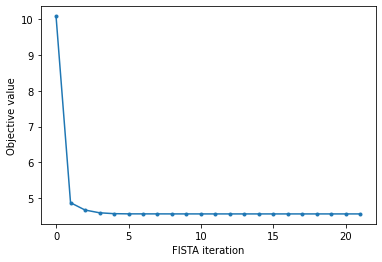

In [10]:
# many solvers let you track information about the optimzation history
est = Glm(solver=FISTA(tracking_level=1) # tell FISTA to track some of the data
          ).fit(X, y)


# this data is stored under the opt_info_ attribute
est.opt_info_.keys()

# these quantities are tracked no matter the tracking level
print('FISTA took {} steps and {:1.5f} seconds to run'.format(est.opt_info_['iter'],
                                                              est.opt_info_['runtime']))

# plot the objective funciton history
# since tracking_level >=1 FISTA stores the objective function history
objective_history = est.opt_info_['history']['objective']
plt.plot(objective_history, marker='.')
plt.ylabel("Objective value")
plt.xlabel("FISTA iteration")

# other GLM parameters



In [11]:
# lets check out the other init options for all Glms
Glm.__init__

<function yaglm.base.BaseGlm.__init__(self, loss='lin_reg', penalty=None, constraint=None, standardize=True, fit_intercept=True, solver='default', lla=True, initializer='default', inferencer=None)>

In [12]:
# standardization, which is applied by default, means mean centering and scaling
# Note that after fitting the coefficient on the processed data we transform
# the coefficient/intercept back to the original scale of the data!
Glm(standardize=True).fit(X, y)

# Our standardization routines work the same with sparse and matrices!
# I.e. we (lazily) mean center sparse matrices 
# using the scipy.sparse.linalg.LinearOperator class
from scipy.sparse import csr_matrix
Glm(standardize=True).fit(csr_matrix(X), # X is a sparse matrix format here!
                          y)

Glm()

In [13]:
# we can turn intercepts off if we really want to
Glm(fit_intercept=False).fit(X, y)

Glm(fit_intercept=False)

The following arguments are discussed in later notebook

- The `initializer` argument is only used for flavored penalties e.g. adaptive Lasso, SCAD.

- The `inferencer` argument is used for running statistial inference routines e.g. estimating the number of degrees of freedom.